In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib

%matplotlib inline

sns.set_style('whitegrid')  # set a fancy seaborn style for the plots

# add time converter for matplotlib visualisation
pd.plotting.register_matplotlib_converters()

# The analysis of the import/export data

In this notebook you can find the analysis of the trading data that was gained from two different sources:

- **[FAOSTAT](http://www.fao.org/faostat/en/#data) website** which contains the data about the *agricultural production*, *livestock quantit*y, and more importantly *the trading data of crop and livestock products*.
- **[OEC](https://oec.world/en/resources/data/) website** which contains the bilateral data about the product trade between different countries. It initially uses the \[[1](#References)\] paper which is a study that comprises the analysis of 50-year trading data.

## FAOSTAT DATA

We will start with the reading and preprocessing of the FAOSTAT dataset. The necessary data is [here](http://fenixservices.fao.org/faostat/static/bulkdownloads/Trade_Crops_Livestock_E_All_Data_(Normalized).zip) and it consists of folder with two files: `Trade_Crops_Livestock_E_All_Data_(Normalized).csv` and `Trade_Crops_Livestock_E_Flags.csv`. The initial *Normalised* version of the data will be used for future analysis and should be renamed as `trading_data.csv`.

The obtained `trading_data.csv` file is quite big \~ 1.6 GB, so we will not upload it to the remote GitHub version of the project.

In [117]:
# The path to FAO data
fao_path = '../data/fao/'

# Reading the dataset from csv file and leaving only needed columns
trading_data_normalized = pd.read_csv(fao_path + 'trading_data.csv', encoding='latin-1')
trading_data = trading_data_normalized[['Area', 'Item', 'Element', 'Year', 'Unit', 'Value']]

# Renaming columns
trading_data = trading_data.rename(columns={
    'Area': 'country',
    'Item': 'item',
    'Element': 'value_meaning',
    'Year': 'year',
    'Value': 'value',
    'Unit': 'unit'
})

# Convert the year to a datetime object
trading_data['year'] = pd.to_datetime(trading_data['year'], format='%Y')

# Leaving only the Import Quantity and the Export Quantity
trading_data = trading_data[(trading_data['value_meaning'] == 'Import Quantity') | (trading_data['value_meaning'] == 'Export Quantity')]

Let us get the list of countries in the `trading_data` dataframe.

In [118]:
trading_data['country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belgium-Luxembourg', 'Belize', 'Benin', 'Bermuda', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Chile', 'China',
       'China, Hong Kong SAR', 'China, Macao SAR', 'China, mainland',
       'China, Taiwan Province of', 'Colombia', 'Comoros', 'Congo',
       'Cook Islands', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba',
       'Cyprus', 'Czechia', 'Czechoslovakia',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', '

We can see that in the end of this list we have rows indicating not the countries but the aggregated data (e.g. 'World', 'Africa', 'European Union trade', etc). Let us drop this columns.

In [119]:
# Creating the list of row labels that we need to drop
list_of_aggregated_data_rows = ['World', 'Africa',
       'Eastern Africa', 'Middle Africa', 'Northern Africa',
       'Southern Africa', 'Western Africa', 'Americas',
       'Northern America', 'Central America', 'Caribbean',
       'South America', 'Asia', 'Central Asia', 'Eastern Asia',
       'Southern Asia', 'South-Eastern Asia', 'Western Asia', 'Europe',
       'Eastern Europe', 'Northern Europe', 'Southern Europe',
       'Western Europe', 'Oceania', 'Australia & New Zealand',
       'Melanesia', 'Micronesia', 'Polynesia', 'EU(12)ex.int',
       'EU(15)ex.int', 'EU(25)ex.int', 'EU(27)ex.int', 'European Union',
       'European Union (exc intra-trade)', 'Least Developed Countries',
       'Land Locked Developing Countries',
       'Small Island Developing States',
       'Low Income Food Deficit Countries',
       'Net Food Importing Developing Countries']

# Drop the unnecessary rows
trading_data = trading_data.set_index('country').drop(index=list_of_aggregated_data_rows).reset_index()

Let us calculate the number of rows with NaN values.

In [120]:
print('The number of rows with NaN values is: %d out of %d' % (trading_data[pd.isnull(trading_data).any(axis=1)].shape[0], trading_data.shape[0]))

The number of rows with NaN values is: 1321355 out of 5922832


We can see that we have a **huge** number of rows with NaN values. In scope of our project we treat these values as zero, because in most cases we will focus only on the specific major trading products when comparing different countries that do not contain NaN values.

In [121]:
# Filling the NaN values with 0
trading_data.fillna(0, inplace=True)

Now we can separate the import data and the export data for future analysis.

In [122]:
# Creating additional dataframes for keeping import and export data
import_data = trading_data[trading_data['value_meaning'] == 'Import Quantity']
export_data = trading_data[trading_data['value_meaning'] == 'Export Quantity']

Let us see how many distinct trading products do we have in each dataset.

In [123]:
print('The number of distinct trading products in import dataset is: %d' % len(import_data['item'].unique()))
print('The number of distinct trading products in export dataset is: %d' % len(export_data['item'].unique()))

The number of distinct trading products in import dataset is: 452
The number of distinct trading products in export dataset is: 446


We can see that in our dataset we have a **huge** diversity of the trading products. It will be convenient to sort them by the average import and export value over the time period - in that case we will have the most important products with the biggest trading (import or export) value above. We will create two additional dataframes `import_data_sorted` and `export_data_sorted` which keeps the biggest trading (based on the average import/export value) products above.

In [124]:
# Create the dataframe which contains the biggest import products for each country
import_data_sorted = (import_data.groupby(['country', 'item'])
                           # calculate the mean for each country and for each item over the time period
                           .mean()
                              # then group by country
                               .groupby(level='country', group_keys=False)
                                  # and sort the items by the average values over the years
                                   .apply(lambda x: x.sort_values(by='value', ascending=False))
                                      # create a column which contains the average import value 
                                      # for each item for specific country
                                       .rename(columns={'value': 'average_import_value'})
                      )

# Create the dataframe which contains the biggest export products for each country
export_data_sorted = (export_data.groupby(['country', 'item'])
                           # calculate the mean for each country and for each item over the time period
                           .mean()
                               # then group by country
                               .groupby(level='country', group_keys=False)
                                   # and sort the items by the average values over the years
                                   .apply(lambda x: x.sort_values(by='value', ascending=False))
                                       # create a column which contains the average import value 
                                       # for each item for specific country
                                       .rename(columns={'value': 'average_export_value'})
                      )

In [125]:
# Show the country and the biggest import products in a nice way
import_data_sorted.groupby(level='country', group_keys=False).apply(lambda df: df.nlargest(n=3, columns='average_import_value')).head(20)

average_import_value
country             item                                              
Afghanistan         Cereals                               5.898406e+05
                    Wheat+Flour,Wheat Equivalent          5.210205e+05
                    Sugar Raw Centrifugal                 2.988893e+05
Albania             Cereals                               2.358327e+05
                    Wheat+Flour,Wheat Equivalent          1.977996e+05
                    Wheat                                 1.473262e+05
Algeria             Cereals                               5.005716e+06
                    Wheat+Flour,Wheat Equivalent          3.571040e+06
                    Wheat                                 3.093106e+06
American Samoa      Milk Equivalent                       3.368625e+03
                    Total Meat                            2.858214e+03
                    Cereals                               2.556804e+03
Angola              Cereals                               4.163060e+05
                    Wheat+Flour,Wheat Equivalent          2.449849e+05
                    Beverages                             1.509927e+05
Antigua and Barbuda Beverages                             5.920536e+03
                    Cereals                               5.452268e+03
                    Milk Equivalent                       5.032839e+03
Argentina           Oilseeds                              2.167728e+05
                    Bananas and plantains                 2.110490e+05

In [126]:
# Show the country and the biggest export products in a nice way
export_data_sorted.groupby(level='country', group_keys=False).apply(lambda df: df.nlargest(n=3, columns='average_export_value')).head(20)

average_export_value
country             item                                          
Afghanistan         Raisins                           3.588202e+04
                    Grapes                            3.018829e+04
                    Vegetables, fresh nes             1.763130e+04
Albania             Vegetables, fresh nes             1.886545e+04
                    Tomatoes                          1.068041e+04
                    Beverages                         7.931393e+03
Algeria             Beverages                         2.902509e+05
                    Wine+Vermouth+Sim.                2.828663e+05
                    Wine                              2.792099e+05
American Samoa      Pet food                          6.626418e+03
                    Fodder & Feeding stuff            6.508786e+03
                    Cotton lint                       1.574500e+03
Angola              Coffee Green+Roast                5.623784e+04
                    Coffee, green                     5.623650e+04
                    Cereals                           3.117533e+04
Antigua and Barbuda Sugar and Honey                   2.764107e+03
                    Sugar,Total (Raw Equiv.)          2.327019e+03
                    Sugar Raw Centrifugal             2.327019e+03
Argentina           Cereals                           1.619998e+07
                    Fodder & Feeding stuff            1.084092e+07

For future analysis we will focus on the Lebanon. This country has been in civil war (which is called [Lebanese Civil War](https://en.wikipedia.org/wiki/Lebanese_Civil_War)) from 1975 to 1990 which we are particularly interested in this project.

Let us show the top 3 biggest import and export products in Lebanon.

In [127]:
print('The top 3 import products in Lebanon are:', import_data_sorted.loc['Lebanon'].nlargest(n=3, columns='average_import_value').index.tolist(),
      '\nThe top 3 export products in Lebanon are:', export_data_sorted.loc['Lebanon'].nlargest(n=3, columns='average_export_value').index.tolist())

The top 3 import products in Lebanon are: ['Cereals', 'Wheat+Flour,Wheat Equivalent', 'Wheat'] 
The top 3 export products in Lebanon are: ['Oranges+Tang+Clem', 'Potatoes', 'Oranges']


## OEC DATA

Let us also download the raw version of the OEC dataset which contains the bilateral trading information - every import/export value has the *origin_country* and *destination_country*. This way we can know between which countries the trade was done.

The file provided [here](https://atlas.media.mit.edu/static/db/raw/year_origin_destination_sitc_rev2.tsv.bz2) is very big (compressed version is \~ 700 MB), that is why we will create a pickle file that will contain only necessary data. The next cell, that creates this pickle file, will be run once and then not used.

The initial `year_origin_destination_sitc_rev2.tsv.bz2` file has product attributes that are classified using [SITC (Standard International Trade Classification)](https://en.wikipedia.org/wiki/Standard_International_Trade_Classification), and country attributes which are 3-char coded. The deciphering of the attributes is presented [here](https://atlas.media.mit.edu/static/db/raw/products_sitc_rev2.tsv.bz2) for product attributes and [here](https://atlas.media.mit.edu/static/db/raw/country_names.tsv.bz2) for country attributes. The product attributes comprise a huge diversity of products: from technical machinery, pharmacy products, to agricultural products. In this project we focus on the impact of the war on the crop trading so we define manually a list of the crop product attributes in the `food_titles` variable.

We again focus only on Lebanon trading data, hence the preprocessed `lebanon_trading_data_destinations.pkl` will contain only info about Lebanon. The country and product attributes will be renamed and presented in a more friendly manner.

In [128]:
# RUN THE ANALYSIS OF OEC DATA FROM THIS CELL

# The path to the OEC data
oec_path = '../data/oec/'

# Read the preprocessed pickle file of the OEC data
lebanon_trading_data_destinations = pd.read_pickle(oec_path + 'lebanon_trading_data_destinations.pkl')

Let us calculate the number of rows with NaN values as we did before with FAO data.

In [129]:
print('The number of rows with NaN values is: %d our of %d' % (lebanon_trading_data_destinations[pd.isnull(lebanon_trading_data_destinations).any(axis=1)].shape[0], lebanon_trading_data_destinations.shape[0]))

The number of rows with NaN values is: 41485 our of 257433


Again we fill NaN values with zero.

In [130]:
# Filling the NaN values with 0
lebanon_trading_data_destinations.fillna(0, inplace=True)

As we will show after, the trading data for some products is doubled - both *the origin* and *the destination countries* have reported about the trade, hence some rows are contain information about the same trade. To erase this ambuguity we implemented a function `delete_twin_rows` that finds and delete one of the duplicate rows.

In [131]:
# The processing of this cell will take a while... 
def reverse_attributes(row):   
    """
        The function is used to reverse the origin_country/destination_country attributes and 
        import_value/export_value attributes to erase the ambuguity of the data. The function
        is applied for each row. After applying the function the origin_country column
        has only Lebanon attribute.
    """
    
    changed_row = row.copy()

    if row['origin_country'] != 'Lebanon':
        changed_row['origin_country'], changed_row['destination_country'] = row['destination_country'], row['origin_country']
        changed_row['import_value'], changed_row['export_value'] = row['export_value'], row['import_value']
    
    return changed_row

print('The length of the initial dataset was %d' % lebanon_trading_data_destinations.shape[0])

# Deleting the duplicate rows
lebanon_trading_data_destinations = lebanon_trading_data_destinations.transform(reverse_attributes, axis='columns') \
                                                                         .drop_duplicates()
print('The length of the processed dataset was %d' % lebanon_trading_data_destinations.shape[0])

# Delete the origin_country column as it is useless now
lebanon_trading_data_destinations.drop(columns='origin_country', inplace=True)

The length of the initial dataset was 257433
The length of the processed dataset was 151611


## Main analysis of the datasets

Firsly, let us plot the import and export values for the Lebanon.

In [132]:
# Calculating the summed import and export values for each country
import_summed_data = import_data.groupby(['country', 'year']).sum().rename(columns={'value': 'total_import_value'})
export_summed_data = export_data.groupby(['country', 'year']).sum().rename(columns={'value': 'total_export_value'})

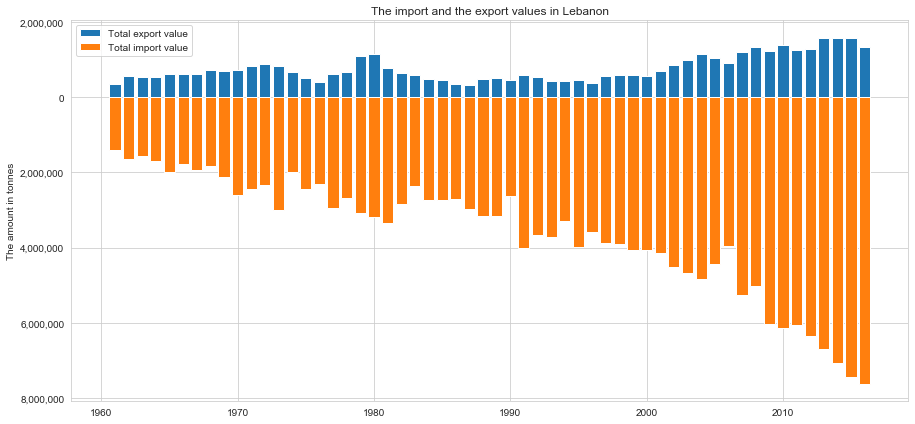

In [133]:
import matplotlib.ticker as ticker

def plot_import_export(import_data, export_data, country):
    
    f, ax = plt.subplots(figsize=(15, 7))
    timedates = export_data.loc[country].index
    
    ax.bar(timedates, export_data.loc[country]['total_export_value'].values, width=300, align='center', label='Total export value')
    ax.bar(timedates, (-import_data).loc[country]['total_import_value'].values, width=300, align='center', label='Total import value')
    
    #ax.set_yscale('symlog')
    ax.set_title('The import and the export values in %s' % country)
    ax.set_ylabel('The amount in tonnes');
    ax.legend()
    
    @ticker.FuncFormatter
    def yaxis_formatter(x, pos):
        label = f'{-int(x):,}' if x < 0 else f'{int(x):,}'
        return label
    
    ax.yaxis.set_major_formatter(yaxis_formatter)
    

plot_import_export(import_summed_data, export_summed_data, 'Lebanon')

## References

[1] Feenstra, R. C., et al. (2005). World Trade Flows, 1962–2000. NBER working paper 11040